In [530]:
from k_means_constrained import KMeansConstrained
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
from itertools import permutations
from shapely.geometry import Polygon, LineString, Point
from shapely.ops import split,nearest_points
from newton_multidimention import Optimize_Drone_Position_Euclidean

background = mpimg.imread('./map.png')
plt.style.use('default')

In [531]:
def create_polygon(points):
    coords = []

    for pt in points:
        coords.append(pt)

    obs_polygon = Polygon(coords)
    return obs_polygon

In [532]:
def create_locations(x, y, n, obstacles):
    loc = []
    obstacle_polygon = [create_polygon(obs) for obs in obstacles.values()]

    while len(loc) < n:
        loc_x = random.uniform(x[0], y[0])
        loc_y = random.uniform(x[1], y[1])
        
        if all(not Point([loc_x, loc_y]).intersects(obs) for obs in obstacle_polygon):
            loc.append([loc_x, loc_y])

    return loc

## Distance Calculation

In [533]:
def calculate_distance(point1, point2):
    point1 = np.array(point1)
    point2 = np.array(point2)
    return np.sqrt(np.sum((point1 - point2)**2))

def total_distance(clusters):
    total = 0
    for i in clusters:
        pts = clusters[i]
        for j in range(len(pts)-1):
            total += calculate_distance(pts[j], pts[j+1])
    
    return total

## Plotting

In [534]:
def initial_plot(delivery_loc, obstacles):
    plt.imshow(background, extent=[22.21,34.45,88.45,98.67])
    loc = np.array(delivery_loc)
    plt.scatter(loc[:,0], loc[:,1])
    for obstacle_id, points in obstacles.items():
        x = [i for i,j in points]
        y = [j for i,j in points]

        plt.fill(x,y,color="red", alpha = 0.3)
    plt.title("Delivery Locations")
    # plt.grid(True)
    # plt.xticks(np.arange(22.21,34.45,0.1), rotation='vertical')
    # plt.yticks(np.arange(88.45,98.67,0.1))

    # mpldatacursor.datacursor()
    plt.show()

In [535]:
def clusters_plot(clusters, centroids, obstacles):
    plt.imshow(background, extent=[22.21,34.45,88.45,98.67])
    for i in clusters:
        points = np.array(clusters[i])
        plt.scatter(points[:,0], points[:,1])
        #try
        # center = np.mean(points, axis=0)
        # radius = max(np.linalg.norm(point - center) for point in points)

        # # Plot the circle
        # circle = plt.Circle(center, radius, color='lightblue', fill=True, alpha=0.5)
        # plt.gca().add_artist(circle)
        #try
    plt.scatter(centroids[:,0], centroids[:,1], marker='^', c="black")
    for obstacle_id, points in obstacles.items():
        x = [i for i,j in points]
        y = [j for i,j in points]
        
        plt.fill(x,y,color="red", alpha = 0.3)
    plt.title("After Clustering")
    plt.show()

In [536]:
def dp_plot(clusters, centroids, dp, obstacles):
    plt.imshow(background, extent=[22.21,34.45,88.45,98.67])
    for i in clusters:
        points = np.array(clusters[i])
        plt.scatter(points[:,0], points[:,1])
        #try
        # center = np.mean(points, axis=0)
        # radius = max(np.linalg.norm(point - center) for point in points)

        # # Plot the circle
        # circle = plt.Circle(center, radius, color='lightblue', fill=True, alpha=0.5)
        # plt.gca().add_artist(circle)
        #try
    plt.scatter(centroids[:,0], centroids[:,1], marker='^', c="black")
    plt.scatter(dp[0], dp[1], marker='+',s=200, c="red")
    for obstacle_id, points in obstacles.items():
        x = [i for i,j in points]
        y = [j for i,j in points]

        plt.fill(x,y,color="red", alpha = 0.3)
    plt.title("After DP Creation")
    plt.show()

In [537]:
def final_plot(delivery_loc,clusters, dp, obstacles, title=None):
    plt.imshow(background, extent=[22.21,34.45,88.45,98.67])
    colors = ['blue', 'green', 'orange', 'purple', 'brown']

    deliveries = np.array(delivery_loc)
    plt.scatter(deliveries[:,0], deliveries[:,1])

    for i in clusters:
        pts = np.array(clusters[i])
        # plt.scatter(pts[:,0], pts[:,1])
        #try
        # points = pts[1:-1,:]
        # center = np.mean(points, axis=0)
        # radius = max(np.linalg.norm(point - center) for point in points)

        # # Plot the circle
        # circle = plt.Circle(center, radius, color='lightblue', fill=True, alpha=0.5)
        # plt.gca().add_artist(circle)
        #try

        for j in range(len(pts)-1):
            pt_1 = pts[j]
            pt_2 = pts[j+1]

            plt.plot([pt_1[0], pt_2[0]], [pt_1[1], pt_2[1]], c=colors[i % len(colors)])

    plt.scatter(dp[0], dp[1], c="red", marker='X',s=200)
    for obstacle_id, points in obstacles.items():
        x = [i for i,j in points]
        y = [j for i,j in points]

        plt.fill(x,y,color="red", alpha = 0.3)
    if title != None:
        plt.title(title)
    else:
        plt.title("Final Result")
    # plt.show()

## KMeans

In [538]:
def KMeans(delivery_loc, n, k):
    n_cluster = n//k if n%k == 0 else n//k + 1

    model = KMeansConstrained(n_clusters=n_cluster, size_min=1, size_max=k)
    model.fit_predict(np.array(delivery_loc))

    labels = model.labels_
    clusters = {label:[] for label in range(n_cluster)}

    for i in range(len(delivery_loc)):
        clusters[labels[i]].append(delivery_loc[i])

    return model.cluster_centers_, clusters

## DP Calculation

In [539]:
def calculate_dp(centroids):
    x = [i for i,j in centroids]
    y = [j for i,j in centroids]

    loc_x = np.mean(x)
    loc_y = np.mean(y)

    return [loc_x, loc_y]

In [540]:
def relocate_dp(dp, obstacle_polygon):
    near_point = nearest_points(obstacle_polygon.exterior, dp)

    near_point = near_point[0].coords[0]

    return near_point

In [541]:
def varify_dp(dp, obstacles):
    new_dp = None
    cur_dp = Point([dp[0],dp[1]])

    for obs_id, obstacle in obstacles.items():
        obstacle_polygon = create_polygon(obstacle)
        
        if obstacle_polygon.contains(cur_dp):
            new_dp = relocate_dp(cur_dp, obstacle_polygon)
            break
    
    return dp if new_dp == None else new_dp

## TSP

## Obstacles Free path

In [542]:
def line_intersect(line, obstacle):
    parts = split(obstacle, line)

    count = len([geoms for geoms in parts.geoms])

    return count != 1

In [543]:
def is_obstacle_free(line, obstacles):
    for obs in obstacles:
        if line_intersect(line,obs):
            return False
    return True

In [544]:
import networkx as nx

def create_shortest_path(point_1, point_2, obstacles):
    route_line = LineString([point_1, point_2])

    intersections = []
    # for obstacle in obstacles:
    #     for i in range(len(obstacle.exterior.coords) - 1):
    #         start, end = obstacle.exterior.coords[i], obstacle.exterior.coords[i + 1]
    #         line = LineString([start, end])
    #         if route_line.intersects(line):
    #             intersections.append(start)
    #             intersections.append(end)

    for obstacle in obstacles:
        if route_line.intersects(obstacle):
            for cord in range(len(obstacle.exterior.coords)-1):
                intersections.append(obstacle.exterior.coords[cord])

    # Create a graph
    G = nx.Graph()

    # Add nodes for each point in the space
    G.add_node(tuple(point_1))

    for inter_point in intersections:
        G.add_node(tuple(inter_point))
    
    G.add_node(tuple(point_2))

    # create new polygon
    # for id,obstacle in enumerate(obstacles):
    #     obstacles[id] = scale_polygon(obstacle)

    # Add edges between adjacent points (up, down, left, right)
    for cur in G.nodes():
        for next in G.nodes():
            if cur == next:
                continue
            line = LineString([cur, next])
            if is_obstacle_free(line, obstacles):
                G.add_edge(cur, next)

    # Find the shortest path using A*
    start = tuple(point_1)
    goal = tuple(point_2)
    path = nx.astar_path(G, start, goal, heuristic=calculate_distance)

    # pos = {node: node for node in G.nodes()}
    # nx.draw(G, pos, node_color='lightgray', with_labels=True)
    # nx.draw_networkx_nodes(G, pos, nodelist=[start], node_color='green')
    # nx.draw_networkx_nodes(G, pos, nodelist=[goal], node_color='red')
    # nx.draw_networkx_edges(G, pos, edgelist=[(path[i], path[i+1]) for i in range(len(path)-1)], edge_color='blue', width=2)
    # plt.title('Path Planning with Obstacle Avoidance')
    # plt.show()

    return path

In [545]:
def merge_dp(cluster, entry_exit_dp, obstacles):
    obstacle_polygon = []
    for obs_id, obs in obstacles.items():
        obstacle_polygon.append(create_polygon(obs))

    path_1 = create_shortest_path(entry_exit_dp, cluster[0], obstacle_polygon)
    path_2 = create_shortest_path(cluster[-1],entry_exit_dp, obstacle_polygon)
    
    new_cluster = path_1 + cluster + path_2

    return new_cluster

In [546]:
def check_obstacle_in_line(point_a, point_b, obstacles):
  line = LineString([point_a, point_b])

  for obstacle in obstacles:
    if line.intersects(obstacle):
      # intermediate_point = find_inter_point(point_a, point_b, obstacles)
      intermediate_point = create_shortest_path(point_a, point_b, obstacles.copy())
      distance = 0

      for pts in range(len(intermediate_point)-1):
        distance += calculate_distance(intermediate_point[pts], intermediate_point[pts + 1])

      return distance, intermediate_point

  return calculate_distance(point_a, point_b), None

In [547]:
def create_distance_matrix(points,obstacles,dp=None):
    matrix = {}
    inter_matrix = {}
    obstacle_polygon = []
    for obs_id, obs in obstacles.items():
        obstacle_polygon.append(create_polygon(obs))

    if dp != None:
        points.append(dp)
    for src in points:
        for dest in points:
            src_point = tuple(src)
            dest_point = tuple(dest)
            distance,inter = check_obstacle_in_line(src_point, dest_point, obstacle_polygon)
            matrix[(src_point, dest_point)] = distance
            if inter != None:
                inter_matrix[(src_point, dest_point)] = inter
    
    return matrix, inter_matrix

## TSP

In [548]:
def initial_tsp(cluster, dp, method="christofides"):
    
    if method == "christofides":
        path = cluster
        path.append(dp)
        path.insert(0, dp)

        G = nx.Graph()

        for pt in path:
            G.add_node(tuple(pt))

        for i in range(len(path)-1):
            for j in range(i+1,len(path)):
                G.add_edge(tuple(path[i]),tuple(path[j]), weight = calculate_distance(path[i], path[j]))

        path = nx.approximation.traveling_salesman.christofides(G, weight='weight')
    
    elif method == 'brut_force':
        path = list(permutations(cluster))
        cost = []
        # add dp at the start and end
        for i in range(len(path)):
            path[i] = list(path[i])
            path[i].append(dp)
            path[i].insert(0, dp)

            # Calculate distance
            points = path[i]
            sum = 0

            for j in range(len(points)-1):
                sum += calculate_distance(points[j], points[j+1])
            cost.append(sum)

        idx = np.argmin(cost)
        path = path[idx]

        print("Path ",path)

    return path

In [549]:
def tsp_crysto(cluster, dp, obstacles):
    distance_matrix, inter_point_matrix = create_distance_matrix(cluster, obstacles, dp)
    
    path = cluster
    path.append(dp)
    path.insert(0, dp)

    G = nx.Graph()

    for pt in path:
        G.add_node(tuple(pt))

    for i in range(len(path)-1):
        for j in range(i+1,len(path)):
            G.add_edge(tuple(path[i]),tuple(path[j]), weight = distance_matrix[(tuple(path[i]), tuple(path[j]))])

    path = nx.approximation.traveling_salesman.christofides(G, weight='weight')
    entry_exit = []
    entry_exit.append(path[1])
    entry_exit.append(path[-2])
    #insert intermediate points
    ans_route = []
    for loc in range(len(path)-1):
        ans_route.append(path[loc])
        if inter_point_matrix.get((tuple(path[loc]), tuple(path[loc + 1]))):
            intermediate_points =  inter_point_matrix[(tuple(path[loc]), tuple(path[loc + 1]))]
            for i in range(1,len(intermediate_points)-1):
                ans_route.append(intermediate_points[i])
    ans_route.append(dp)
    

    return ans_route, entry_exit
    # return ans_route

In [550]:
from itertools import permutations

def tsp_brut(cluster, dp, obstacles):
    paths = list(permutations(cluster))
    distance_matrix, inter_point_matrix = create_distance_matrix(cluster, obstacles, dp)
    distance_list = []

    # work start
    for cur in paths:
        path = list(cur)
        path.append(dp)
        path.insert(0, dp)

        # distance calculation
        distance = 0
        for loc in range (len(path)-1):
            distance += distance_matrix[(tuple(path[loc]), tuple(path[loc + 1]))]
        distance_list.append(distance)

    # getting the minimum distance and path
    entry_exit = []
    min_path = list(paths[np.argmin(distance_list)])
    min_path.append(dp)
    min_path.insert(0,dp)
    min_dist = distance_list[np.argmin(distance_list)]
    # entry_exit.append(min_path[1])
    # entry_exit.append(min_path[-2])

    #insert intermediate points
    ans_route = []
    for loc in range(len(min_path)-1):
        ans_route.append(min_path[loc])
        if inter_point_matrix.get((tuple(min_path[loc]), tuple(min_path[loc + 1]))):
            intermediate_points =  inter_point_matrix[(tuple(min_path[loc]), tuple(min_path[loc + 1]))]
            for i in range(1,len(intermediate_points)-1):
                ans_route.append(intermediate_points[i])
    ans_route.append(dp)

    print("Optimal path",min_path,"optimal distance",min_dist)

    return ans_route
    # work end




from itertools import permutations

def tsp_brut2(cluster, dp, obstacles):
    paths = list(permutations(cluster))
    distance_matrix, inter_point_matrix = create_distance_matrix(cluster, obstacles, dp)
    distance_list = []

    # work start
    for cur in paths:
        path = list(cur)
        path.append(dp)
        path.insert(0, dp)

        # distance calculation
        distance = 0
        for loc in range (len(path)-1):
            distance += distance_matrix[(tuple(path[loc]), tuple(path[loc + 1]))]
        distance_list.append(distance)

    # getting the minimum distance and path
    entry_exit = []
    min_path = list(paths[np.argmin(distance_list)])
    min_path.append(dp)
    min_path.insert(0,dp)
    min_dist = distance_list[np.argmin(distance_list)]
    entry_exit.append(min_path[1])
    entry_exit.append(min_path[-2])

    #insert intermediate points
    ans_route = []
    for loc in range(len(min_path)-1):
        ans_route.append(min_path[loc])
        if inter_point_matrix.get((tuple(min_path[loc]), tuple(min_path[loc + 1]))):
            intermediate_points =  inter_point_matrix[(tuple(min_path[loc]), tuple(min_path[loc + 1]))]
            for i in range(1,len(intermediate_points)-1):
                ans_route.append(intermediate_points[i])
    ans_route.append(dp)

    print("Optimal path",min_path,"optimal distance",min_dist)

    return ans_route, entry_exit
    # work end





## MAIN

In [551]:
x = [22.21, 88.45]
y = [34.45, 98.67]
n=15
k=5

obstacles = {
    0 : [[27.81, 90.75],[28.74, 91.42],[27.80, 93.15], [26.81, 92.53], [27.81, 90.75]],
    1 : [[23.11, 91.25], [24.81, 92.40], [24.21, 93.45], [22.51, 92.35],[23.11, 91.25]],
    2 : [[24.55, 88.60],[25.96, 89.55],[25.01, 91.35],[23.61, 90.32],[24.55, 88.60]],
    3 : [[25.60, 88.45], [27.42, 88.45],[26.92, 89.35],[25.60, 88.45]],
    4 : [[27.61, 88.45], [28.81, 88.45],[29.12, 88.66],[28.02, 90.45],[26.90, 89.57],[27.61, 88.45]],
    5 : [[25.33, 92.62], [25.86, 92.95], [25.21, 94.15], [24.69, 93.78], [25.33, 92.63]],
    6 : [[26.11, 93.05], [26.62, 93.35], [25.81, 94.65], [25.39, 94.35], [26.11, 93.05]],
    7 : [[26.72, 93.65], [27.32, 94.05], [26.69, 95.18], [26.10, 94.83], [26.72, 93.65]],
    8 : [[25.81, 95.40],[26.29, 95.70],[26.01, 96.20],[26.25, 96.37],[25.93, 96.94],[25.80, 96.84], [25.69, 97.01],[25.11, 96.65],[25.81, 95.40]],
    9 : [[23.90, 94.15], [24.91, 94.81], [24.48, 95.57],[23.48, 94.95],[23.90, 94.15]],
    10 : [[23.71, 98.67], [23.91, 98.26], [24.41, 98.67],[23.71, 98.67]],
    11 : [[31.81, 90.35], [32.51, 90.85], [32.21, 91.55], [32.03, 91.85], [34.31, 93.45], [32.69, 96.27],[30.99, 95.15], [32.21, 92.93],[30.89, 91.97],[31.81, 90.35]],
    12 : [[30.21, 96.00],[31.85, 97.11], [31.02, 98.55], [30.50, 98.26], [30.31, 98.53], [30.51, 98.67],[27.81, 98.67], [27.21, 98.28], [27.73, 97.43],[28.95, 98.25],[30.21, 96.00]]
}

delivery_loc = create_locations(x, y, n, obstacles)

len(delivery_loc)


15

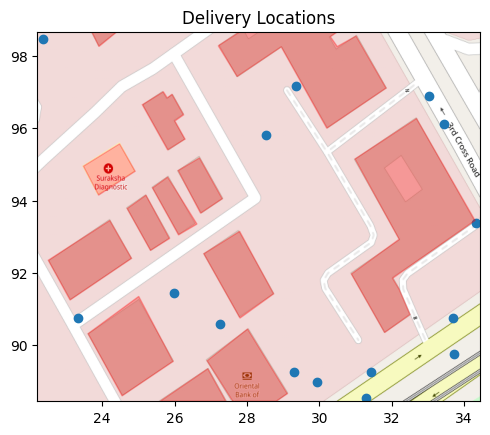

In [552]:
initial_plot(delivery_loc, obstacles)

{0: [[27.25195124409933, 90.59971088437855], [22.369273306151232, 98.46286003329969], [23.336780657945056, 90.76629441985983], [25.98714082776308, 91.44875883248629], [28.528851334952716, 95.79973978706668]], 1: [[31.43782635004249, 89.2541166906487], [33.71537327690515, 89.77053555276865], [31.301622466314527, 88.54309763329805], [29.311127360616396, 89.26087697230902], [29.94975078910577, 88.97205285680435]], 2: [[33.04877715677237, 96.9041455518488], [33.444432335915366, 96.10922204745015], [33.696933276096395, 90.76224752832388], [34.33025226344796, 93.38742989067278], [29.357435834555957, 97.18059071761805]]}


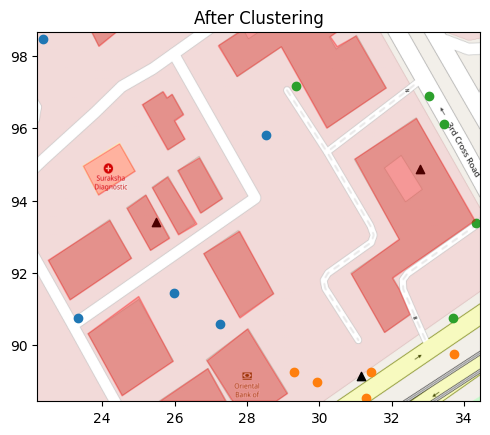

In [553]:
# Cluster the data and get the labels and centroids

centroids, clusters = KMeans(delivery_loc, n, k)

print(clusters)

# Visualize the data
clusters_plot(clusters, centroids, obstacles)
cluster_1 = clusters.copy()
cluster_2 = clusters.copy()
cluster_3 = clusters.copy()
cluster_4 = clusters.copy()
cluster_5 = clusters.copy()

DP [29.80450189871225, 92.48144529325556]
[29.80450189871225, 92.48144529325556]


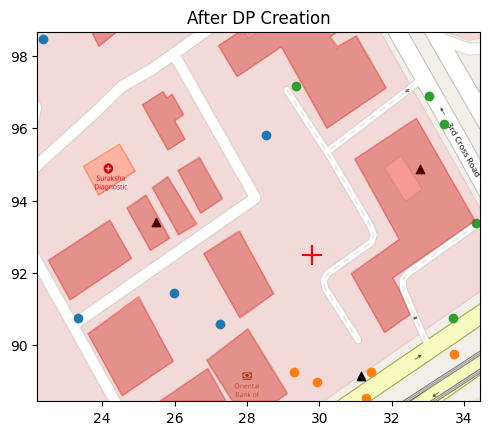

In [554]:

DP = calculate_dp(centroids)
print("DP",DP)
DP = varify_dp(DP, obstacles)
print(DP)
dp_plot(clusters, centroids, DP, obstacles)


Path  [[29.80450189871225, 92.48144529325556], [27.25195124409933, 90.59971088437855], [25.98714082776308, 91.44875883248629], [23.336780657945056, 90.76629441985983], [22.369273306151232, 98.46286003329969], [28.528851334952716, 95.79973978706668], [29.80450189871225, 92.48144529325556]]
Path  [[29.80450189871225, 92.48144529325556], [33.71537327690515, 89.77053555276865], [31.43782635004249, 89.2541166906487], [31.301622466314527, 88.54309763329805], [29.94975078910577, 88.97205285680435], [29.311127360616396, 89.26087697230902], [29.80450189871225, 92.48144529325556]]
Path  [[29.80450189871225, 92.48144529325556], [33.696933276096395, 90.76224752832388], [34.33025226344796, 93.38742989067278], [33.444432335915366, 96.10922204745015], [33.04877715677237, 96.9041455518488], [29.357435834555957, 97.18059071761805], [29.80450189871225, 92.48144529325556]]


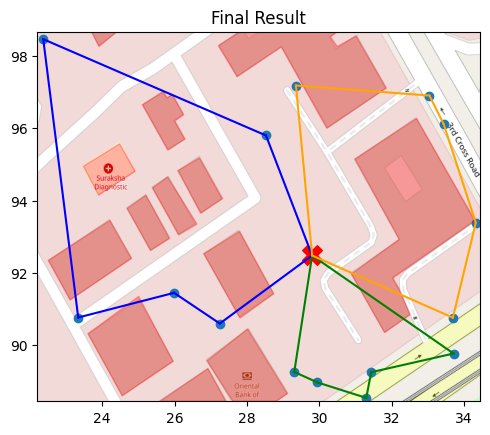

In [555]:
for i in cluster_1:
    cluster_1[i] = initial_tsp(cluster_1[i], DP, method="brut_force")

final_plot(delivery_loc,cluster_1, DP, obstacles)

## christofides and Newton

Entry Exit  [(28.528851334952716, 95.79973978706668), (27.25195124409933, 90.59971088437855)]


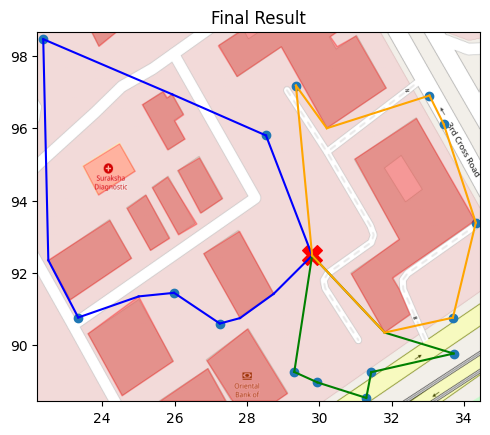

In [556]:
entry_exit = []

for i in cluster_2:
    cluster_2[i],ee_points = tsp_crysto(cluster_2[i].copy(), DP, obstacles)
    entry_exit.append(ee_points)
# cluster_2[0],ee_points = tsp_crysto(cluster_2[0].copy(), DP, obstacles)
# entry_exit.append(ee_points)

print("Entry Exit ",entry_exit[0])

final_plot(delivery_loc,cluster_2, DP, obstacles)
# total_distance(cluster_2)


In [557]:
entry_nodes = []
exit_nodes = []
entry_exit_nodes = []
for nodes in entry_exit:
    entry_nodes.append(nodes[0])
    exit_nodes.append(nodes[1])
    entry_exit_nodes.append(nodes[0])
    entry_exit_nodes.append(nodes[1])
    
entry_nodes,exit_nodes,entry_exit_nodes

([(28.528851334952716, 95.79973978706668),
  (33.71537327690515, 89.77053555276865),
  (33.696933276096395, 90.76224752832388)],
 [(27.25195124409933, 90.59971088437855),
  (29.311127360616396, 89.26087697230902),
  (29.357435834555957, 97.18059071761805)],
 [(28.528851334952716, 95.79973978706668),
  (27.25195124409933, 90.59971088437855),
  (33.71537327690515, 89.77053555276865),
  (29.311127360616396, 89.26087697230902),
  (33.696933276096395, 90.76224752832388),
  (29.357435834555957, 97.18059071761805)])

In [558]:
entry_exit_dp =[]
entry_exit_dp = calculate_dp(entry_exit_nodes)
print(entry_exit_dp,DP)
entry_exit_dp = Optimize_Drone_Position_Euclidean(entry_nodes, exit_nodes, entry_exit_dp)[0]

print(entry_exit_dp)

[30.310278721204327, 92.22895024041081] [29.80450189871225, 92.48144529325556]
New Drone: [30.24930326 91.55892963]
[30.24930326 91.55892963]


In [559]:
entry_exit_dp = varify_dp(entry_exit_dp, obstacles)
type(DP)

list

In [560]:


for i in cluster_3:
    entry_exit = entry_exit_dp.tolist() if not isinstance(entry_exit_dp, list) else entry_exit_dp
    cluster_3[i],ee_points = tsp_crysto(cluster_3[i].copy(), entry_exit, obstacles)

In [561]:
for cls_id, cluster in cluster_2.items():
    cluster_2[cls_id] = merge_dp(cluster, DP, obstacles)

for cls_id, cluster in cluster_3.items():
    cluster_3[cls_id] = merge_dp(cluster, entry_exit_dp, obstacles)

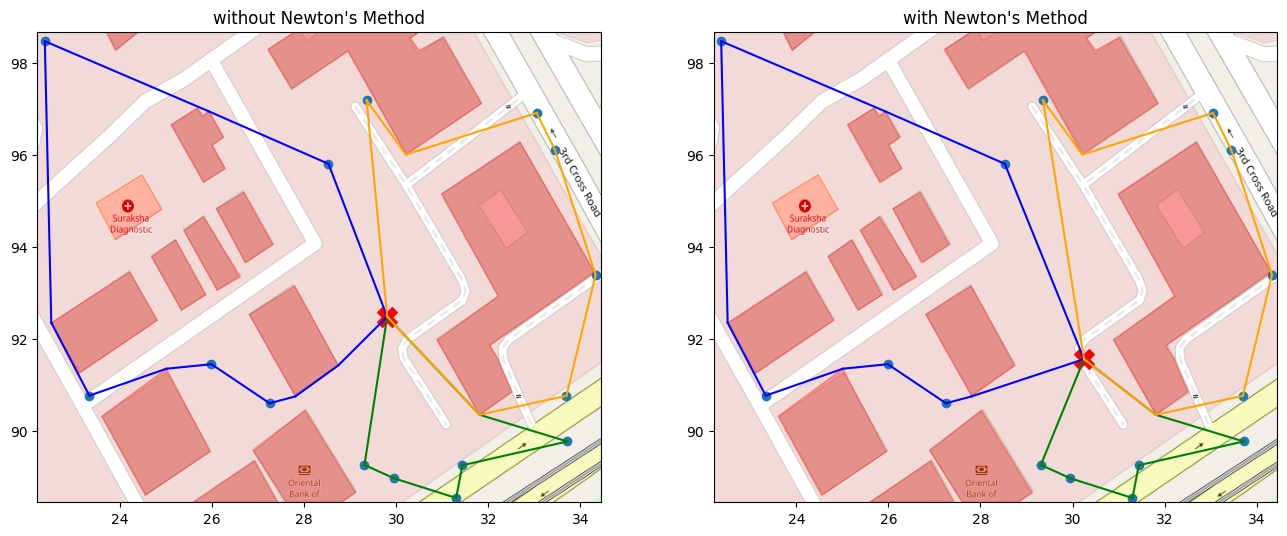

In [562]:
# final_plot(delivery_loc,cluster_2, DP, obstacles)
# final_plot(delivery_loc,cluster_3, entry_exit_dp, obstacles)
plt.figure(figsize=(16,14))

plt.subplot(2,2,1)
final_plot(delivery_loc,cluster_2, DP, obstacles,title="without Newton's Method")
plt.subplot(2,2,2)
final_plot(delivery_loc,cluster_3, entry_exit_dp, obstacles, title="with Newton's Method")

## Brut_force with centroids DP

In [563]:
EE_points = []
for i in cluster_4:
    cluster_4[i],eepoints = tsp_brut2(cluster_4[i].copy(), DP, obstacles)
    EE_points.append(eepoints)

Optimal path [[29.80450189871225, 92.48144529325556], [28.528851334952716, 95.79973978706668], [22.369273306151232, 98.46286003329969], [23.336780657945056, 90.76629441985983], [25.98714082776308, 91.44875883248629], [27.25195124409933, 90.59971088437855], [29.80450189871225, 92.48144529325556]] optimal distance 25.671768769078458
Optimal path [[29.80450189871225, 92.48144529325556], [29.311127360616396, 89.26087697230902], [29.94975078910577, 88.97205285680435], [31.301622466314527, 88.54309763329805], [31.43782635004249, 89.2541166906487], [33.71537327690515, 89.77053555276865], [29.80450189871225, 92.48144529325556]] optimal distance 13.354796345838421
Optimal path [[29.80450189871225, 92.48144529325556], [29.357435834555957, 97.18059071761805], [33.04877715677237, 96.9041455518488], [33.444432335915366, 96.10922204745015], [34.33025226344796, 93.38742989067278], [33.696933276096395, 90.76224752832388], [29.80450189871225, 92.48144529325556]] optimal distance 20.464706626042076


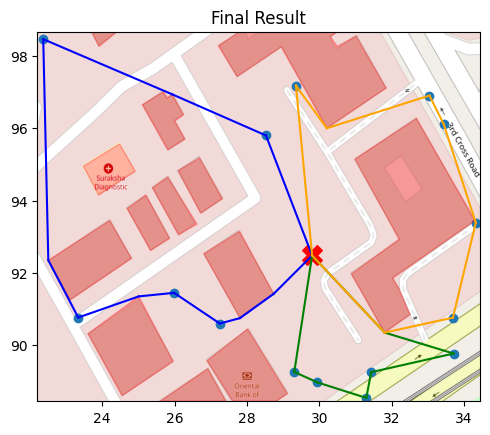

In [564]:
final_plot(delivery_loc,cluster_4, DP, obstacles)

## Brute Force with Newton

In [565]:
entry_nodes = []
exit_nodes = []
entry_exit_nodes = []
for nodes in EE_points:
    entry_nodes.append(nodes[0])
    exit_nodes.append(nodes[1])
    entry_exit_nodes.append(nodes[0])
    entry_exit_nodes.append(nodes[1])
    
entry_nodes,exit_nodes,entry_exit_nodes

NewDP = calculate_dp(entry_exit_nodes)
NewDP = varify_dp(NewDP, obstacles)
NewDP = Optimize_Drone_Position_Euclidean(entry_nodes, exit_nodes, NewDP)[0]
NewDP = varify_dp(NewDP, obstacles)

New Drone: [30.24930326 91.55892963]


In [566]:
for i in cluster_5:
    NewDP = NewDP.tolist() if not isinstance(NewDP, list) else NewDP
    cluster_5[i] = tsp_brut(cluster_5[i].copy(), NewDP, obstacles)

Optimal path [[30.249303263526933, 91.55892963186979], [28.528851334952716, 95.79973978706668], [22.369273306151232, 98.46286003329969], [23.336780657945056, 90.76629441985983], [25.98714082776308, 91.44875883248629], [27.25195124409933, 90.59971088437855], [30.249303263526933, 91.55892963186979]] optimal distance 26.613680229501682
Optimal path [[30.249303263526933, 91.55892963186979], [33.71537327690515, 89.77053555276865], [31.43782635004249, 89.2541166906487], [31.301622466314527, 88.54309763329805], [29.94975078910577, 88.97205285680435], [29.311127360616396, 89.26087697230902], [30.249303263526933, 91.55892963186979]] optimal distance 11.626374678327732
Optimal path [[30.249303263526933, 91.55892963186979], [33.696933276096395, 90.76224752832388], [34.33025226344796, 93.38742989067278], [33.444432335915366, 96.10922204745015], [33.04877715677237, 96.9041455518488], [29.357435834555957, 97.18059071761805], [30.249303263526933, 91.55892963186979]] optimal distance 20.48384899233847

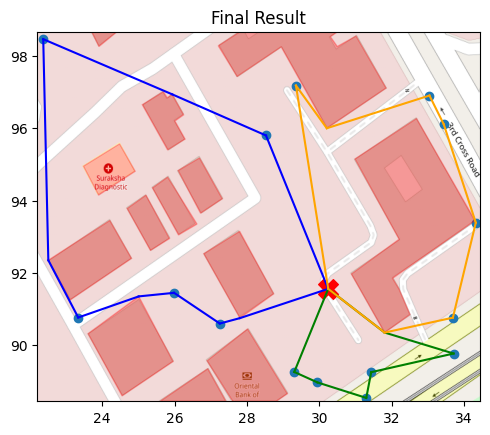

In [567]:
final_plot(delivery_loc,cluster_5, NewDP, obstacles)

Calculate Distance

In [568]:
new_distance1 = total_distance(cluster_1)
print("Total Distance for Brut Force no obstacles: ",new_distance1)

Total Distance for Brut Force no obstacles:  57.77738066383794


In [569]:
new_distance2 = total_distance(cluster_2)
print("Distance considering Christofides :",new_distance2)

Distance considering Christofides : 59.49127174095896


In [570]:
new_distance3 = total_distance(cluster_3)
print("Distance considering Christofides and newton :",new_distance3)

Distance considering Christofides and newton : 58.72390390016789


In [571]:
new_distance4 = total_distance(cluster_4)
print("Distance considering Brute Force :",new_distance4)

Distance considering Brute Force : 59.49127174095896


In [572]:
new_distance5 = total_distance(cluster_5)
print("Distance considering  Brute with newton:",new_distance5)

Distance considering  Brute with newton: 58.72390390016789


## File Storage

In [573]:
import pandas as pd

df = pd.read_csv('./New_drone_performance.csv')
#Without_obstacles,Christofides,Christofides_newton,brut_force_distance,brut_force_Newton
new_row = {
    'delivary_locations':n,
    'drone_capacity':k,
    'obstacles':len(obstacles),
    'Without_obstacles':new_distance1,
    'Christofides':new_distance2,
    'Christofides_newton':new_distance3,
    'brut_force_distance':new_distance4,
    'brut_force_Newton' :new_distance5
}

df.loc[len(df)] = new_row

df.tail(5)

,delivary_locations,drone_capacity,obstacles,Without_obstacles,Christofides,Christofides_newton,brut_force_distance,brut_force_Newton
2,15,5,13,47.267460,54.284439,50.949433,48.500273,48.754930
3,15,5,13,43.938570,46.359761,45.913186,45.973371,45.414230
4,15,5,13,48.613052,51.244240,52.560552,50.107529,51.303145
5,15,5,13,46.805119,53.608414,51.814427,50.898955,50.854772
6,15,5,13,57.777381,59.491272,58.723904,59.491272,58.723904


In [574]:
try:
    df.to_csv('./New_drone_performance.csv', index=False)
except:
    print("Unknown error occurs")